In [39]:
# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

# You only need to authenticate once per session.
auth.authenticate_user()

In [ ]:
# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

# You only need to authenticate once per session.
auth.authenticate_user()

# Import libraries
from datetime import timedelta
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# below imports are used for pretty pandas dataframes and plots
from IPython.display import display, HTML
%matplotlib inline
plt.style.use('ggplot')


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.impute import SimpleImputer

from pandas_profiling import ProfileReport

# Set up environment variables
project_id = 'genuine-box-350018'
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
    return pd.io.gbq.read_gbq(
        query,
        project_id=project_id,
        dialect="standard"
    )

if project_id == 'CHANGE-ME':
  raise ValueError('You must change project_id to your GCP project at the top of this cell.')

# test it works
df = run_query("""
SELECT *
FROM `physionet-data.mimic_core.patients`
WHERE subject_id = 10012853
""")
assert df.shape[0] >= 1, 'unable to query MIMIC!'
display(df)

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10012853,F,91,2175,2014 - 2016,NaT


**MORTALITY LABELS**

In [40]:
mortality = run_query("""
SELECT *
FROM `genuine-box-350018.rnn_dataset.final-cohort-table`
""")
display(mortality)

/usr/local/lib/python3.7/dist-packages/google/cloud/bigquery/table.py:1582: FutureWarning: Data is timezone-aware. Converting timezone-aware data to timezone-naive by passing dtype='datetime64[ns]' to DataFrame or Series is deprecated and will raise in a future version. Use `pd.Series(values).dt.tz_localize(None)` instead.
  bqstorage_client=bqstorage_client, dtypes=dtypes


,subject_id,stay_id,hadm_id,intime,year,deathtime,death_status
0,10157718,30185469,24943658,2164-02-21 23:58:01+00:00,2009,NaT,0
1,10249925,32593030,28164030,2122-12-29 23:50:00+00:00,2009,NaT,0
2,10311956,36577532,25628815,2123-03-06 23:58:05+00:00,2009,NaT,0
3,10329846,35463345,28917992,2139-12-16 20:22:00+00:00,2009,NaT,0
4,10431718,36653742,20415490,2157-09-09 11:31:16+00:00,2009,NaT,0
...,...,...,...,...,...,...,...
21889,13393674,37425449,23351991,2121-05-07 00:42:09+00:00,2012,2121-05-09 17:03:00+00:00,1
21890,16131968,38118615,25993458,2136-07-14 12:28:45+00:00,2012,2136-07-17 14:50:00+00:00,1
21891,16483343,33171103,27615389,2117-02-07 02:06:25+00:00,2012,2117-03-16 01:55:00+00:00,1
21892,16734321,37307350,28193892,2111-02-17 14:51:00+00:00,2012,2111-02-24 07:00:00+00:00,1


In [ ]:
print(mortality['year'].unique())

[2009 2010 2011 2012]


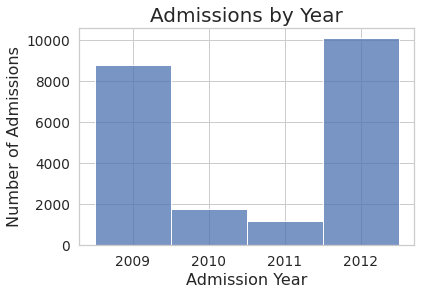

In [ ]:
# Number of admissions each year
fig, ax = plt.subplots()
sns.set(style="whitegrid", font_scale=1)
sns.histplot(data=mortality, x='year',  bins=[2008.5,2009.5,2010.5,2011.5,2012.5], ax=ax)
ax.set_xticks(range(2009, 2013,1))
plt.xlabel("Admission Year", fontsize=16)
plt.ylabel("Number of Admissions", fontsize=16)
plt.title("Admissions by Year", fontsize=20)
plt.show(sns)

In [ ]:
death_per_year = pd.DataFrame({"year": [2009, 2010, 2011, 2012],
                              "total_death": mortality.groupby('year').death_status.sum()})
display(death_per_year)

,year,total_death
year,,
2009,2009,673
2010,2010,94
2011,2011,50
2012,2012,675


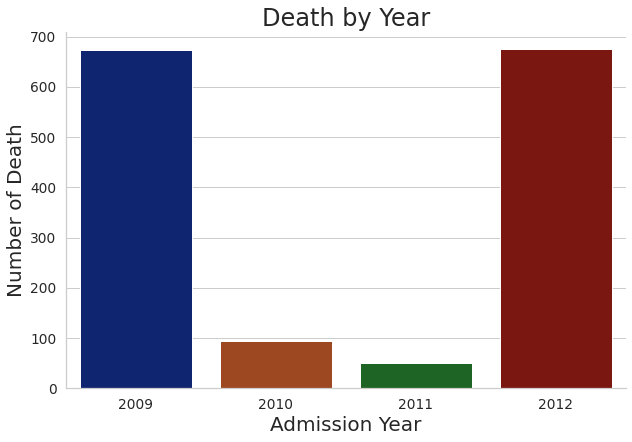

In [ ]:
# Number of death each year
sns.set(style="whitegrid", font_scale=1.25)
sns.catplot(data=death_per_year, kind="bar", x="year", y="total_death",palette="dark", height=6, aspect=1.5)
plt.xlabel("Admission Year", fontsize=20)
plt.ylabel("Number of Death", fontsize=20)
plt.title("Death by Year", fontsize=24)
plt.show(sns)

**ICD-9 Codes**

In [41]:
icd_data = run_query("""
SELECT *
FROM `genuine-box-350018.rnn_dataset.icd-table`
""")
display(icd_data)

,subject_id,hadm_id,stay_id,icd_1,icd_2,icd_3,icd_4,icd_5,icd_6,icd_7,...,icd_11,icd_12,icd_13,icd_14,icd_15,icd_16,icd_17,icd_18,icd_19,icd_20
0,10001217,24597018,37067082,1,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,1,0
1,10002527,29112696,37121704,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,10002760,28094813,31831386,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
3,10003046,26048429,35514836,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10006633,25978757,32905915,0,1,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21887,19985683,25452614,36461568,0,1,1,0,0,1,1,...,0,1,0,0,1,0,0,1,1,1
21888,19985885,24999390,34175243,0,0,1,0,0,0,1,...,0,0,1,0,1,1,0,1,1,1
21889,19988137,22716260,33257394,0,0,1,1,0,0,0,...,1,0,0,0,0,0,0,1,1,1
21890,19991538,26694123,39801924,1,0,1,0,1,1,0,...,0,0,1,0,0,0,0,1,1,1


In [ ]:
# Summing total of each ICD Columns
icd_per_group = pd.DataFrame({"ICD": ['ICD 1', 'ICD 2', 'ICD 3', 'ICD 4', 'ICD 5', 'ICD 6', 'ICD 7', 'ICD 8', 'ICD 9', 'ICD 10', 
                                  'ICD 11', 'ICD 12', 'ICD 13', 'ICD 14', 'ICD 15', 'ICD 16', 'ICD 17', 'ICD 18', 'ICD 19', 'ICD 20'],
                          "icd_total": icd_data.iloc[:,3:23].sum(axis=0)})
display(icd_per_group)

,ICD,icd_total
icd_1,ICD 1,6372
icd_2,ICD 2,4241
icd_3,ICD 3,16454
icd_4,ICD 4,9430
icd_5,ICD 5,9225
icd_6,ICD 6,9167
icd_7,ICD 7,18186
icd_8,ICD 8,10662
icd_9,ICD 9,9876
icd_10,ICD 10,9871


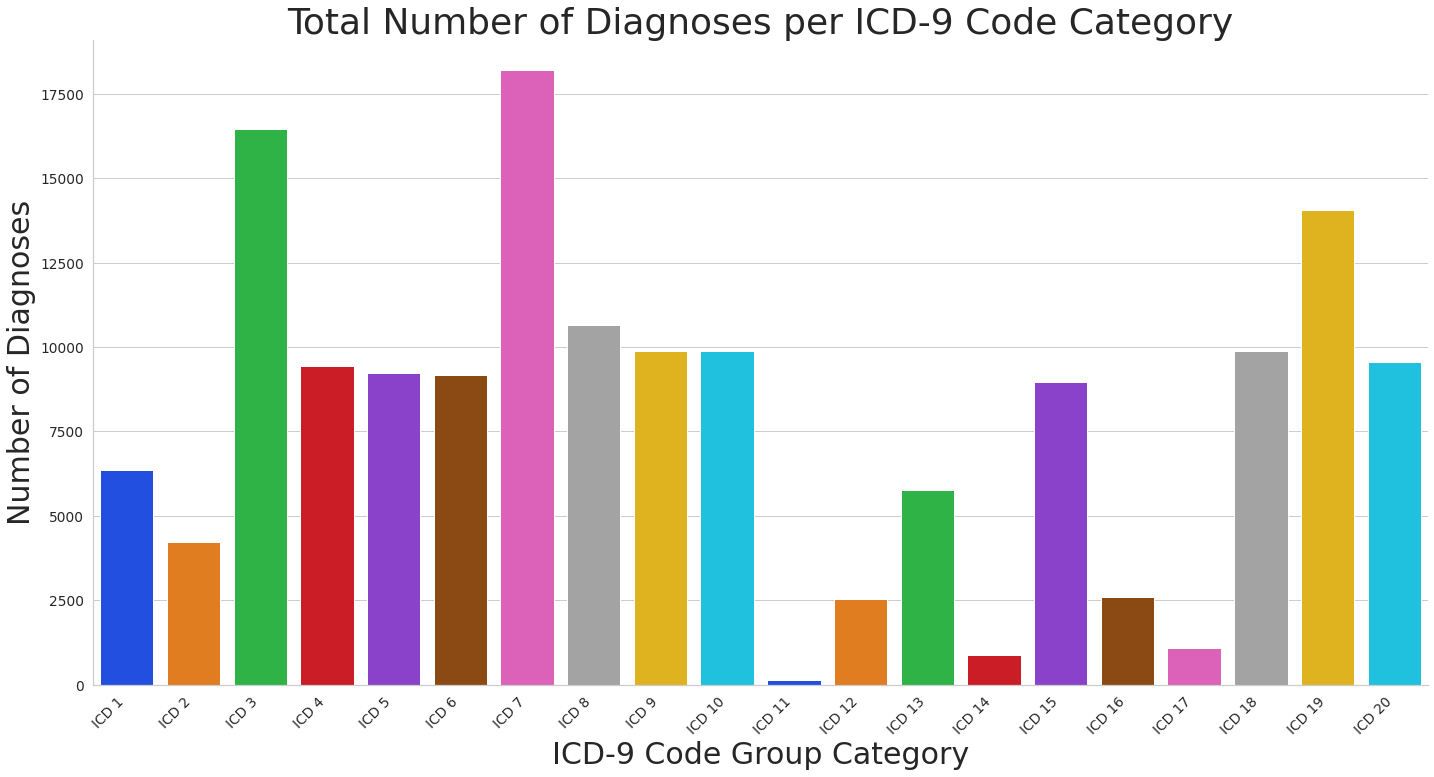

In [167]:
# Total number of diagnoses each ICD-9 code category
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(style="whitegrid", font_scale=1.25)
sns.catplot(data=icd_per_group, kind="bar", x="ICD", y="icd_total",palette="bright", height=10, aspect=2)
plt.xticks(rotation=45, ha="right")
plt.xlabel("ICD-9 Code Group Category", fontsize=30)
plt.ylabel("Number of Diagnoses", fontsize=30)
plt.title("Total Number of Diagnoses per ICD-9 Code Category", fontsize=36)
plt.show()

Assessing missingness of each variable

In [57]:
input_data = run_query(f'''
SELECT *
FROM `genuine-box-350018.rnn_dataset.timeseries-input-table` 
''')
display(input_data)


,subject_id,hadm_id,stay_id,hour,covariate,amount
0,13762560,23892460,39736584,5,Packed Red Blood Cells,350.000010
1,13762560,23892460,39736584,8,Packed Red Blood Cells,350.000010
2,13762560,23892460,39736584,9,Calcium Gluconate,2.000000
3,13762560,23892460,39736584,9,Piggyback,99.999998
4,13762560,23892460,39736584,10,PO Intake,40.000000
...,...,...,...,...,...,...
493600,17299199,26943137,39986042,26,Insulin - Regular,8.000000
493601,15465215,20621314,34764910,2,Dextrose 5%,100.000005
493602,15465215,20621314,34764910,14,Dextrose 5%,69.583337
493603,15465215,20621314,34764910,18,D5 1/2NS,99.999997


In [58]:
input_data = input_data[(1 <= input_data['hour']) & (input_data['hour']<= 48)]

In [59]:
input_data=input_data.rename({'amount':'value'}, axis=1)

In [80]:
# assign indeces for the covariates
input_data.loc[input_data['covariate'] == 'Albumin 5%', 'covariate'] = 16
input_data.loc[input_data['covariate'] == 'Dextrose 5%', 'covariate'] = 17
input_data.loc[input_data['covariate'] == 'Fresh Frozen Plasma', 'covariate'] = 18
input_data.loc[input_data['covariate'] == 'Lorazepam (Ativan)', 'covariate'] = 19
input_data.loc[input_data['covariate'] == 'Calcium Gluconate', 'covariate'] = 20
input_data.loc[input_data['covariate'] == 'Midazolam (Versed)', 'covariate'] = 21
input_data.loc[input_data['covariate'] == 'Phenylephrine', 'covariate'] = 22
input_data.loc[input_data['covariate'] == 'Furosemide (Lasix)', 'covariate'] = 23
input_data.loc[input_data['covariate'] == 'Hydralazine', 'covariate'] = 24
input_data.loc[input_data['covariate'] == 'Norepinephrine', 'covariate'] = 25
input_data.loc[input_data['covariate'] == 'Magnesium Sulfate', 'covariate'] = 26
input_data.loc[input_data['covariate'] == 'Nitroglycerin', 'covariate'] = 27
input_data.loc[input_data['covariate'] == 'Insulin - Regular', 'covariate'] = 28
input_data.loc[input_data['covariate'] == 'Insulin - Glargine', 'covariate'] = 29
input_data.loc[input_data['covariate'] == 'Insulin - Humalog 75/25', 'covariate'] = 30
input_data.loc[input_data['covariate'] == 'Heparin Sodium', 'covariate'] = 31
input_data.loc[input_data['covariate'] == 'Morphine Sulfate', 'covariate'] = 32
input_data.loc[input_data['covariate'] == 'Potassium Chloride', 'covariate'] = 33
input_data.loc[input_data['covariate'] == 'Packed Red Blood Cells', 'covariate'] = 34
input_data.loc[input_data['covariate'] == 'Gastric Meds', 'covariate'] = 35
input_data.loc[input_data['covariate'] == 'D5 1/2NS', 'covariate' ] = 36
input_data.loc[input_data['covariate'] == 'LR', 'covariate' ] = 37
input_data.loc[input_data['covariate'] == 'K Phos', 'covariate' ] = 38
input_data.loc[input_data['covariate'] == 'Solution', 'covariate'] = 39
input_data.loc[input_data['covariate'] == 'Sterile Water', 'covariate'] = 40
input_data.loc[input_data['covariate'] == 'Metoprolol', 'covariate'] = 41
input_data.loc[input_data['covariate'] == 'Piggyback', 'covariate'] = 42
input_data.loc[input_data['covariate'] == 'OR Crystalloid Intake', 'covariate'] = 43
input_data.loc[input_data['covariate'] == 'OR Cell Saver Intake', 'covariate'] = 44
input_data.loc[input_data['covariate'] == 'PO Intake' , 'covariate'] = 45
input_data.loc[input_data['covariate'] == 'GT Flush', 'covariate'] = 46
input_data.loc[input_data['covariate'] == 'KCL (Bolus)', 'covariate' ] = 47
input_data.loc[input_data['covariate'] == 'Magnesium Sulfate (Bolus)', 'covariate' ] = 48

In [82]:
print(input_data['covariate'].unique())

[34 20 42 45 28 23 39 21 33 17 31 19 35 37 43 22 36 18 46 47 26 44 32 27
 38 25 16 40 29 41 24 30]


In [44]:
output_data = run_query(f'''
SELECT *
FROM `genuine-box-350018.rnn_dataset.timeseries-output-table` 
''')
display(output_data)


,subject_id,hadm_id,stay_id,hour,covariate,value
0,13762560,23892460,39736584,9,Void,100.0
1,19072000,28969811,39514141,1,Foley,280.0
2,19072000,28969811,39514141,2,Foley,330.0
3,19072000,28969811,39514141,3,Foley,450.0
4,19072000,28969811,39514141,4,Foley,370.0
...,...,...,...,...,...,...
471548,17299199,26943137,39986042,24,Chest Tube #1,20.0
471549,15465215,20621314,34764910,16,Void,280.0
471550,15465215,20621314,34764910,25,Void,350.0
471551,15465215,20621314,34764910,3,Pre-Admission,800.0


In [46]:
output_data = output_data[(1 <= output_data['hour']) & (output_data['hour']<= 48)]

In [78]:
# assign indeces for the covariates
output_data.loc[output_data['covariate'] == 'Oral Gastric', 'covariate'] = 1
output_data.loc[output_data['covariate'] == 'Stool', 'covariate'] = 2
output_data.loc[output_data['covariate'] == 'OR Urine', 'covariate'] = 3
output_data.loc[output_data['covariate'] == 'Rectal Tube', 'covariate'] = 4
output_data.loc[output_data['covariate'] == 'Foley', 'covariate'] = 5
output_data.loc[output_data['covariate'] == 'Void', 'covariate'] = 6
output_data.loc[output_data['covariate'] == 'Condom Cath', 'covariate'] = 7
output_data.loc[output_data['covariate'] == 'Drainage Bag', 'covariate'] = 8
output_data.loc[output_data['covariate'] == 'Ostomy (output)', 'covariate'] = 9
output_data.loc[output_data['covariate'] == 'Chest Tube #1', 'covariate'] = 10
output_data.loc[output_data['covariate'] == 'Chest Tube #2', 'covariate'] = 11
output_data.loc[output_data['covariate'] == 'Jackson Pratt #1', 'covariate'] = 12
output_data.loc[output_data['covariate'] == 'OR EBL', 'covariate'] = 13
output_data.loc[output_data['covariate'] == 'Pre-Admission', 'covariate'] = 14
output_data.loc[output_data['covariate'] == 'TF Residual', 'covariate'] = 15

In [79]:
print(output_data['covariate'].unique())

[6 5 14 13 3 1 2 10 7 12 15 11 8 9 4]


In [47]:
lab_data = run_query(f'''
SELECT *
FROM `genuine-box-350018.rnn_dataset.timeseries-lab-table` 
''')
display(lab_data)


,subject_id,hadm_id,stay_id,hour,covariate,valuenum_min,valuenum_max
0,10000980,26913865,39765666,12,PT,14.50,14.50
1,10000980,26913865,39765666,12,PTT,69.60,69.60
2,10000980,26913865,39765666,22,Anion Gap,17.00,17.00
3,10000980,26913865,39765666,22,Bicarbonate,23.00,23.00
4,10000980,26913865,39765666,22,"Calcium, Total",9.20,9.20
...,...,...,...,...,...,...,...
2072410,19999987,23865745,36195440,7,Base Excess,1.00,1.00
2072411,19999987,23865745,36195440,7,Calculated Total CO2,28.00,28.00
2072412,19999987,23865745,36195440,7,pCO2,44.00,44.00
2072413,19999987,23865745,36195440,7,pH,7.39,7.39


In [48]:
lab_data = lab_data[(1 <= lab_data['hour']) & (lab_data['hour']<= 48)]

In [49]:
# I will take the average of valuemin and valuemax and create a new column called value
lab_data['value']=(lab_data['valuenum_min']+lab_data['valuenum_max'])/2
lab_data=lab_data.drop(['valuenum_min','valuenum_max'],axis=1)

In [87]:
# assign indeces for the covariates
lab_data.loc[lab_data['covariate'] == 'Hematocrit', 'covariate'] = 49
lab_data.loc[lab_data['covariate'] == 'White Blood Cells', 'covariate'] = 50
lab_data.loc[lab_data['covariate'] == 'Platelet Count', 'covariate' ] = 51
lab_data.loc[lab_data['covariate'] == 'Hemoglobin', 'covariate' ] = 52
lab_data.loc[lab_data['covariate'] == 'MCHC', 'covariate'] = 53
lab_data.loc[lab_data['covariate'] == 'MCH', 'covariate' ] = 54
lab_data.loc[lab_data['covariate'] == 'MCV' , 'covariate'] = 55
lab_data.loc[lab_data['covariate'] == 'Red Blood Cells', 'covariate'] = 56
lab_data.loc[lab_data['covariate'] == 'RDW', 'covariate'] = 57
lab_data.loc[lab_data['covariate'] == 'Potassium', 'covariate' ] = 58
lab_data.loc[lab_data['covariate'] == 'Sodium', 'covariate'] = 59
lab_data.loc[lab_data['covariate'] == 'Chloride', 'covariate'] = 60
lab_data.loc[lab_data['covariate'] == 'Bicarbonate', 'covariate'] = 61
lab_data.loc[lab_data['covariate'] == 'Anion Gap', 'covariate'] = 62
lab_data.loc[lab_data['covariate'] == 'Urea Nitrogen', 'covariate'] = 63
lab_data.loc[lab_data['covariate'] == 'Creatinine', 'covariate' ] = 64
lab_data.loc[lab_data['covariate'] == 'Glucose', 'covariate'] = 65
lab_data.loc[lab_data['covariate'] == 'Magnesium', 'covariate'] = 66
lab_data.loc[lab_data['covariate'] == 'Calcium, Total', 'covariate' ] = 67
lab_data.loc[lab_data['covariate'] == 'Phosphate', 'covariate'] = 68
lab_data.loc[lab_data['covariate'] == 'INR(PT)', 'covariate'] = 69
lab_data.loc[lab_data['covariate'] == 'PT', 'covariate'] = 70
lab_data.loc[lab_data['covariate'] == 'PTT', 'covariate'] = 71
lab_data.loc[lab_data['covariate'] == 'Lymphocytes', 'covariate'] = 72
lab_data.loc[lab_data['covariate'] == 'Monocytes', 'covariate' ] = 73
lab_data.loc[lab_data['covariate'] == 'Neutrophils', 'covariate'] = 74
lab_data.loc[lab_data['covariate'] == 'Basophils', 'covariate'] = 75
lab_data.loc[lab_data['covariate'] == 'Eosinophils' , 'covariate'] = 76
lab_data.loc[lab_data['covariate'] == 'Bilirubin, Total', 'covariate'] = 77
lab_data.loc[lab_data['covariate'] == 'pH', 'covariate'] = 78
lab_data.loc[lab_data['covariate'] == 'Base Excess', 'covariate'] = 79
lab_data.loc[lab_data['covariate'] == 'Calculated Total CO2', 'covariate'] = 80
lab_data.loc[lab_data['covariate'] == 'pO2', 'covariate'] = 81
lab_data.loc[lab_data['covariate'] == 'pCO2', 'covariate'] = 82
lab_data.loc[lab_data['covariate'] == 'PH', 'covariate'] = 83
lab_data.loc[lab_data['covariate'] == 'Specific Gravity', 'covariate'] = 84
lab_data.loc[lab_data['covariate'] == 'Lactate', 'covariate'] = 85
lab_data.loc[lab_data['covariate'] == 'Alanine Aminotransferase (ALT)', 'covariate'] = 86
lab_data.loc[lab_data['covariate'] == 'Asparate Aminotransferase (AST)', 'covariate'] = 87
lab_data.loc[lab_data['covariate'] == 'Alkaline Phosphatase', 'covariate'] = 88
lab_data.loc[lab_data['covariate'] == 'Albumin', 'covariate' ] = 89

In [88]:
print(lab_data['covariate'].unique())

[70 71 62 61 67 60 64 65 49 52 54 53 55 66 68 51 58 57 56 59 63 50 86 89
 88 87 75 77 76 72 73 74 80 82 78 81 85 79 84]


In [60]:
drug = run_query(f'''
SELECT *
FROM `genuine-box-350018.rnn_dataset.timeseries-pres-table` 
''')
display(drug)


,subject_id,hadm_id,stay_id,hour,covariate,dose
0,10000980,26913865,39765666,3,Aspirin,81.0
1,10000980,26913865,39765666,12,Metoprolol Tartrate,12.5
2,10001217,24597018,37067082,-42,Bisacodyl,20.0
3,10001217,24597018,37067082,-42,Docusate Sodium,100.0
4,10001725,25563031,31205490,0,Docusate Sodium,100.0
...,...,...,...,...,...,...
99907,19999840,21033226,38978960,-47,Aspirin,381.0
99908,19999840,21033226,38978960,-3,Metoprolol Tartrate,5.0
99909,19999840,21033226,38978960,20,Potassium Chloride,120.0
99910,19999840,21033226,38978960,30,Bisacodyl,20.0


In [61]:
drug = drug[(1 <= drug['hour']) & (drug['hour']<= 48)]

In [62]:
drug=drug.rename({'dose':'value'}, axis=1)

In [89]:
# assign indeces for the covariates
drug.loc[drug['covariate'] == 'Aspirin', 'covariate'] = 90
drug.loc[drug['covariate'] == 'Bisacodyl' , 'covariate'] = 91
drug.loc[drug['covariate'] == 'Docusate Sodium', 'covariate'] = 92
drug.loc[drug['covariate'] == 'D5W', 'covariate'] = 93
drug.loc[drug['covariate'] == 'Humulin-R Insulin', 'covariate' ] = 94
drug.loc[drug['covariate'] == 'Potassium Chloride', 'covariate'] = 95
drug.loc[drug['covariate'] == 'Magnesium Sulfate', 'covariate'] = 96
drug.loc[drug['covariate'] == 'Metoprolol Tartrate', 'covariate'] = 97
drug.loc[drug['covariate'] == 'Sodium Chloride 0.9% Flush' , 'covariate'] = 98
drug.loc[drug['covariate'] == 'Pantoprazole', 'covariate'] = 99

In [90]:
print(drug['covariate'].unique())

[90 97 91 96 99 95 93 92]


In [99]:
# append all dataframes
data = output_data.append([input_data, lab_data, drug], ignore_index=True)
data = data.drop(['subject_id', 'hadm_id'], axis=1)
data['covariate'].astype(str)
display(data)

,stay_id,hour,covariate,value
0,39736584,9,6,100.0
1,39514141,1,5,280.0
2,39514141,2,5,330.0
3,39514141,3,5,450.0
4,39514141,4,5,370.0
...,...,...,...,...
2471416,32336619,6,92,100.0
2471417,32336619,7,96,8.0
2471418,38978960,20,95,120.0
2471419,38978960,30,91,20.0


In [183]:
# calculate a dataframe to fill
cov = data['covariate'].unique()
missing = pd.DataFrame(columns=cov, index=data['stay_id'].unique())
display(missing)

,6,5,14,13,3,1,2,10,7,12,...,79,84,90,97,91,96,99,95,93,92
39736584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39514141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39376254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37531781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37574767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31382395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35941713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30461247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37843321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [184]:
# counting number of records for each covariate for each stay
count_var=data.groupby(['stay_id','covariate'], as_index=False).agg({'hour':'count'})

In [185]:
for index, row in count_var.iterrows():
  missing.at[row['stay_id'], row['covariate']] = row['hour']/48

In [187]:
# if no missing rate allocated that means 100% missing
missing=missing.apply(pd.to_numeric, downcast='float', errors ='coerce').fillna(1)

In [188]:
pd.set_option('display.float_format', '{:.6f}'.format)
display(missing)

,6,5,14,13,3,1,2,10,7,12,...,79,84,90,97,91,96,99,95,93,92
39736584,0.020833,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.020833,1.000000,1.000000,1.000000
39514141,1.000000,0.645833,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
39376254,0.333333,1.000000,0.020833,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.041667,1.000000,1.000000,0.020833,0.020833,1.000000,0.020833
37531781,0.041667,0.416667,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.020833,1.000000,1.000000,0.020833,1.000000,1.000000,0.020833
37574767,1.000000,0.291667,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.020833,1.000000,0.020833,1.000000,0.041667,0.020833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31382395,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.187500,0.020833,0.020833,1.000000,1.000000,0.020833,1.000000,0.041667,0.041667,0.020833
35941713,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.020833,1.000000,1.000000,1.000000,1.000000,0.020833,1.000000,0.083333,1.000000,1.000000
30461247,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.020833,1.000000,1.000000,1.000000
37843321,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.166667,0.041667,1.000000,0.020833,1.000000,1.000000,0.020833,0.020833,0.041667,0.020833


In [153]:
# Summing total of each ICD Columns
missing_rate = pd.DataFrame({"Covariates": cov,
                          "Missing_Rate": missing.mean(axis=0)})
display(missing_rate)

,Covariates,Missing_Rate
6,6,0.746968
5,5,0.552292
14,14,0.847014
13,13,0.888812
3,3,0.790153
...,...,...
96,96,0.489631
99,99,0.788220
95,95,0.491860
93,93,0.789122


In [155]:
missing_rate=missing_rate.sort_values(by=['Covariates'])
display(missing_rate)

,Covariates,Missing_Rate
1,1,0.814979
2,2,0.973640
3,3,0.790153
4,4,0.996420
5,5,0.552292
...,...,...
93,93,0.789122
95,95,0.491860
96,96,0.489631
97,97,0.681205


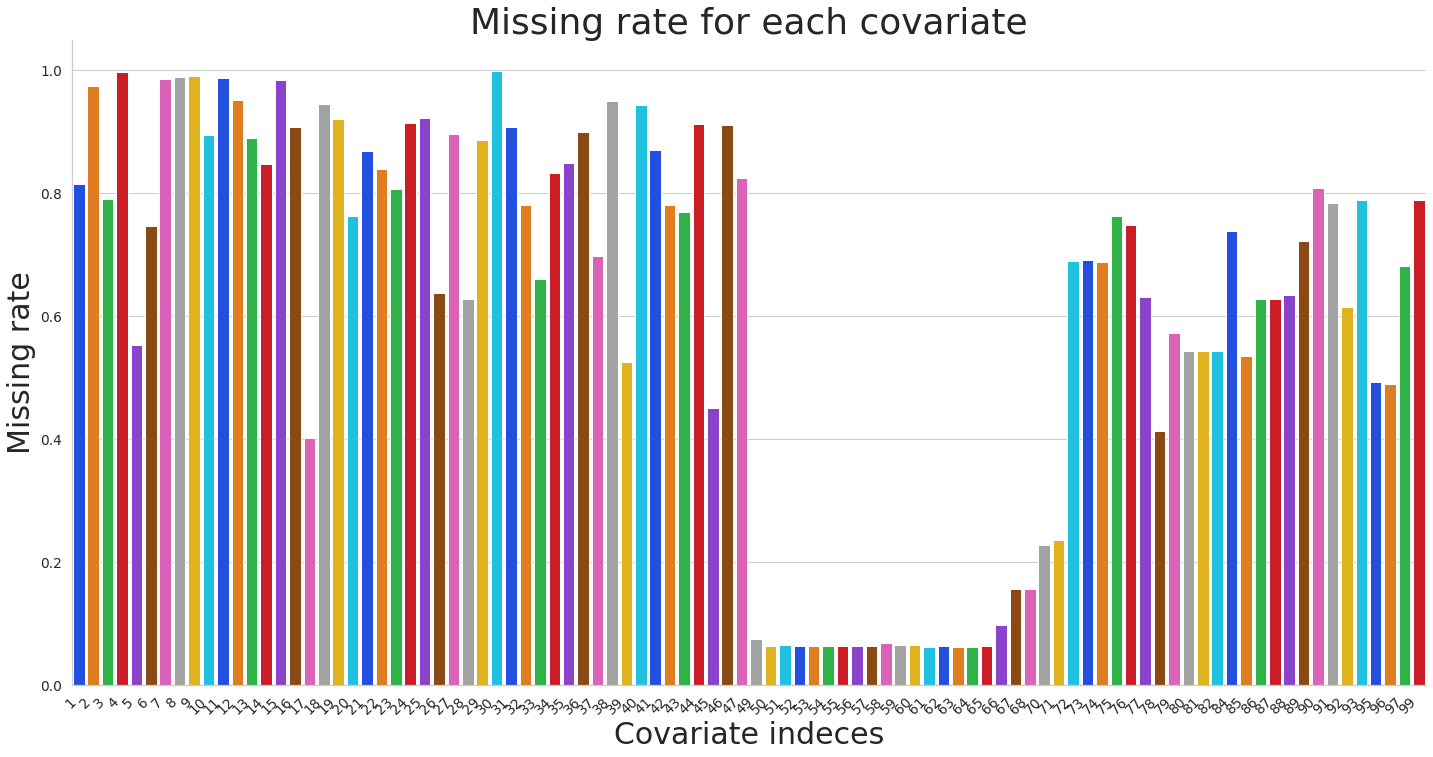

In [166]:
# Missing rate for each variable
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(style="whitegrid", font_scale=1.25)
sns.catplot(data=missing_rate, kind="bar", x="Covariates", y="Missing_Rate",palette="bright", height=10, aspect=2)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Covariate indeces", fontsize=30)
plt.ylabel("Missing rate", fontsize=30)
plt.title("Missing rate for each covariate", fontsize=36)
plt.show()

Correlation with mortality

In [176]:
# Merging mortality and missing dataframes
missing['stay_id'] = missing.index
mortality_missing = pd.merge(mortality, missing, on=['stay_id'])
mortality_missing=mortality_missing.drop(['subject_id','hadm_id','intime','year','deathtime','stay_id'],axis=1)
display(mortality_missing)

,death_status,6,5,14,13,3,1,2,10,7,...,79,84,90,97,91,96,99,95,93,92
0,0,1.000000,0.270833,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.041667,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0,1.000000,0.416667,1.000000,0.020833,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.020833,1.000000,0.020833,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,0,1.000000,0.354167,1.000000,0.020833,0.020833,1.000000,1.000000,1.000000,1.000000,...,0.083333,1.000000,1.000000,1.000000,0.020833,0.020833,1.000000,0.041667,1.000000,0.020833
3,0,0.208333,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.020833,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,0,1.000000,0.479167,1.000000,1.000000,0.020833,0.020833,1.000000,0.395833,1.000000,...,0.208333,1.000000,1.000000,0.020833,1.000000,0.020833,0.020833,0.020833,0.020833,0.020833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21875,1,1.000000,0.437500,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.062500,1.000000,1.000000,1.000000,1.000000,1.000000,0.020833,1.000000,0.020833,1.000000
21876,1,1.000000,0.333333,1.000000,1.000000,1.000000,0.041667,1.000000,1.000000,1.000000,...,0.125000,1.000000,1.000000,1.000000,1.000000,1.000000,0.020833,0.020833,0.020833,1.000000
21877,1,1.000000,0.854167,0.020833,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.104167,0.020833,0.020833,0.041667,1.000000,0.041667,0.020833,0.020833,0.020833,1.000000
21878,1,1.000000,0.270833,0.020833,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.020833,1.000000,0.041667,1.000000,0.020833,1.000000,0.020833,1.000000,0.041667


In [190]:
# Calculating correlation of mortality label with each variable
cov.sort()
mortality_corr = []
for x in cov:
  mortality_corr.append(mortality_missing['death_status'].corr(mortality_missing[x]))

mortality_corr = list(map(abs, mortality_corr))

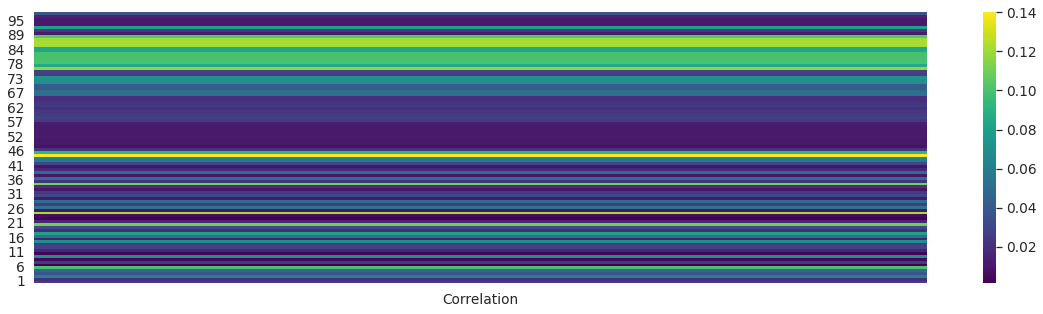

In [237]:
mortality_corr_df = pd.DataFrame({'Correlation':mortality_corr},
                                  index=cov)

fig, ax = plt.subplots(figsize=(20,5))
ax=sns.heatmap(mortality_corr_df , fmt="g", cmap='viridis')
ax.invert_yaxis()
plt.show()

Correlation with ICD codes

In [211]:
# Merging icd and missing dataframes
missing['stay_id'] = missing.index
icd_missing = pd.merge(icd_data, missing, on=['stay_id'])
icd_missing=icd_missing.drop(['subject_id','hadm_id','stay_id'],axis=1)
display(icd_missing)

,icd_1,icd_2,icd_3,icd_4,icd_5,icd_6,icd_7,icd_8,icd_9,icd_10,...,79,84,90,97,91,96,99,95,93,92
0,1,0,0,0,1,1,1,1,0,0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0,0,1,0,0,0,1,0,0,0,...,0.041667,1.000000,0.020833,0.020833,0.020833,0.020833,1.000000,0.062500,0.020833,0.041667
2,0,0,0,0,0,0,1,0,0,0,...,0.208333,1.000000,1.000000,0.020833,0.020833,0.020833,1.000000,0.041667,0.041667,0.041667
3,0,1,1,0,0,0,0,0,1,0,...,0.062500,1.000000,1.000000,1.000000,1.000000,0.020833,0.020833,0.020833,1.000000,1.000000
4,0,1,1,0,0,0,1,0,0,0,...,0.083333,1.000000,1.000000,0.041667,1.000000,0.020833,1.000000,0.041667,0.020833,0.041667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21873,0,1,1,0,0,1,1,0,0,1,...,0.020833,1.000000,1.000000,1.000000,1.000000,0.020833,0.020833,0.020833,1.000000,1.000000
21874,0,0,1,0,0,0,1,0,0,1,...,1.000000,0.020833,1.000000,0.041667,1.000000,1.000000,1.000000,0.020833,0.020833,1.000000
21875,0,0,1,1,0,0,0,1,1,1,...,1.000000,0.020833,1.000000,1.000000,0.020833,0.041667,1.000000,1.000000,0.020833,1.000000
21876,1,0,1,0,1,1,0,1,1,1,...,0.062500,1.000000,1.000000,0.020833,0.020833,0.020833,1.000000,0.020833,1.000000,1.000000


In [222]:
# Calculating correlation of each of ICD categories with missing rates of each covariate
icd = ['icd_1','icd_2','icd_3','icd_4','icd_5','icd_6','icd_7','icd_8','icd_9','icd_10','icd_11','icd_12','icd_13','icd_14','icd_15','icd_16','icd_17','icd_18','icd_19','icd_20',]
icd_corr = pd.DataFrame([])
for x in range(len(cov)):
  for i in range(len(icd)):
    icd_corr.at[i,x] =  icd_missing[icd[i]].corr(icd_missing[cov[x]])
  
icd_corr = icd_corr.abs()


In [223]:
display(icd_corr)

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,93
0,0.009178,0.070613,0.112232,0.051821,0.033664,0.102267,0.022883,0.087419,0.047022,0.138168,...,0.241730,0.178664,0.060184,0.039805,0.144015,0.062232,0.021436,0.007913,0.107753,0.079031
1,0.022136,0.020993,0.041421,0.003029,0.027978,0.005072,0.016933,0.014974,0.012787,0.069557,...,0.028515,0.031841,0.101449,0.024915,0.074092,0.104856,0.092199,0.056716,0.063187,0.049913
2,0.000323,0.024905,0.022131,0.019444,0.003084,0.098364,0.010667,0.018018,0.015105,0.061956,...,0.058206,0.041498,0.102860,0.021514,0.021682,0.087585,0.039400,0.037718,0.118440,0.039561
3,0.023326,0.090178,0.078734,0.041125,0.018503,0.047474,0.019318,0.042664,0.032830,0.046558,...,0.168871,0.115265,0.020654,0.047865,0.075414,0.004353,0.011290,0.003531,0.067107,0.115632
4,0.013616,0.001037,0.091290,0.017954,0.034612,0.003663,0.012069,0.009651,0.000430,0.109523,...,0.093111,0.059593,0.047636,0.028604,0.080674,0.097380,0.036499,0.040454,0.086002,0.031725
5,0.006755,0.027243,0.016882,0.001803,0.057940,0.089264,0.007938,0.014427,0.002574,0.089644,...,0.007092,0.033692,0.018918,0.010026,0.021910,0.065120,0.037905,0.039247,0.029229,0.011774
6,0.002048,0.003783,0.021582,0.005307,0.005756,0.118308,0.034768,0.006444,0.010595,0.115771,...,0.005679,0.012439,0.186605,0.037975,0.085457,0.183080,0.051182,0.059318,0.254104,0.024796
7,0.037086,0.015669,0.056099,0.020233,0.033992,0.143876,0.020756,0.024157,0.023258,0.034178,...,0.123422,0.098544,0.002268,0.017341,0.114406,0.002601,0.012792,0.000845,0.025791,0.056142
8,0.044231,0.108297,0.044126,0.049104,0.016711,0.032547,0.026065,0.079046,0.071058,0.078970,...,0.189787,0.132681,0.059276,0.056303,0.135956,0.047367,0.008323,0.013972,0.046692,0.241700
9,0.029858,0.052127,0.133636,0.032386,0.045465,0.140504,0.012093,0.039625,0.046053,0.105200,...,0.151184,0.109432,0.029598,0.036894,0.074210,0.037595,0.073108,0.066329,0.002362,0.064873


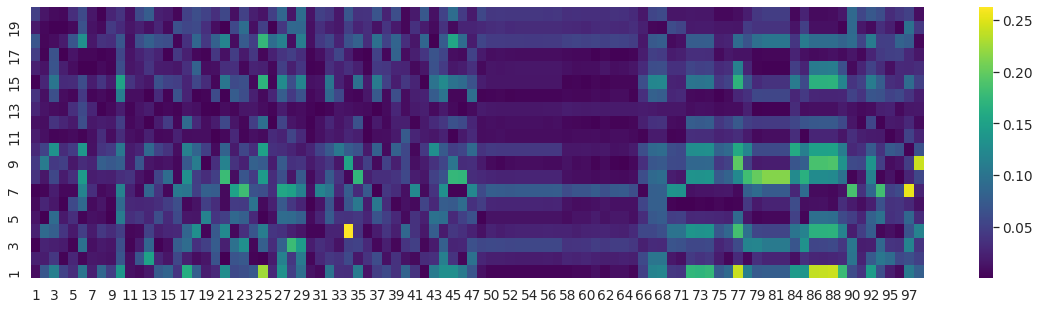

In [236]:
icd_corr.index = range(1,21,1)
icd_corr.columns = cov

fig, ax = plt.subplots(figsize=(20,5))
ax=sns.heatmap(icd_corr , fmt="g", cmap='viridis')
ax.invert_yaxis()
plt.show()